<a href="https://colab.research.google.com/github/JCobz0714/Entrega-1-Analisis-De-Algoritmos/blob/main/Entrega1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# Limpiamos
!rm -f *.o _hmm.so hmm.py hmm_wrap.cxx

In [7]:
# Instalamos la libreía SWIG
!apt-get install swig
!apt-get update
!apt-get install -y swig g++




Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 35 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 1s (1,236 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 126435 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.deb ...
Unpacking swig4.0 (4.0.2-1ubuntu1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_4.0.2-1ubu

In [8]:
## Aquí creamos y escribimos en el archivo hmmm.h
## Luego, declaramos las funciones de la librería.
%%writefile hmm.h
#include <vector>

// Declaraciones de funciones que expondrá la librería
double evaluar(const std::vector<int>& secuencia);
std::vector<int> reconocer(const std::vector<int>& secuencia);


Overwriting hmm.h


In [9]:
## Aquí creamos y escribimos en el archivo hmm.cpp
%%writefile hmm.cpp
#include "hmm.h"
#include <vector>
#include <cmath>
#include <limits>

// ======================================================
// Modelo fijo del ejemplo (2 estados: H=0, L=1; 4 símbolos: A=0, C=1, G=2, T=3)
// ======================================================
static const int N_STATES = 2;
static const int ALPHABET = 4;

static const double PI[N_STATES] = {0.5, 0.5}; // inicial
static const double A[N_STATES][N_STATES] = {
    {0.5, 0.5}, // desde H
    {0.4, 0.6}  // desde L
};
static const double B[N_STATES][ALPHABET] = {
    {0.2, 0.3, 0.3, 0.2}, // H: emisiones A,C,G,T
    {0.3, 0.2, 0.2, 0.3}  // L: emisiones A,C,G,T
};

// ======================================================
// FUNCION EVALUAR: Algoritmo Forward
// ======================================================
double evaluar(const std::vector<int>& secuencia) {
    int T = (int)secuencia.size();
    if (T == 0) return 0.0;

    std::vector<std::vector<double>> alpha(T, std::vector<double>(N_STATES));

    // Inicialización
    int o0 = secuencia[0];
    for (int j = 0; j < N_STATES; ++j) {
        alpha[0][j] = std::log(PI[j]) + std::log(B[j][o0]);
    }

    // Recursión
    for (int t = 1; t < T; ++t) {
        int ot = secuencia[t];
        for (int j = 0; j < N_STATES; ++j) {
            double maxVal = -std::numeric_limits<double>::infinity();
            for (int i = 0; i < N_STATES; ++i) {
                double val = alpha[t-1][i] + std::log(A[i][j]);
                if (val > maxVal) maxVal = val;
            }
            double sumExp = 0.0;
            for (int i = 0; i < N_STATES; ++i) {
                double val = alpha[t-1][i] + std::log(A[i][j]);
                sumExp += std::exp(val - maxVal);
            }
            alpha[t][j] = maxVal + std::log(sumExp) + std::log(B[j][ot]);
        }
    }

    // Terminación
    double maxFinal = -std::numeric_limits<double>::infinity();
    for (int j = 0; j < N_STATES; ++j) {
        if (alpha[T-1][j] > maxFinal) maxFinal = alpha[T-1][j];
    }
    double sumExp = 0.0;
    for (int j = 0; j < N_STATES; ++j) {
        sumExp += std::exp(alpha[T-1][j] - maxFinal);
    }
    double logP = maxFinal + std::log(sumExp);

    return std::exp(logP); // probabilidad normal
}

// ======================================================
// FUNCION RECONOCER: Algoritmo Viterbi
// ======================================================
std::vector<int> reconocer(const std::vector<int>& secuencia) {
    int T = (int)secuencia.size();
    if (T == 0) return {};

    std::vector<std::vector<double>> delta(T, std::vector<double>(N_STATES));
    std::vector<std::vector<int>> psi(T, std::vector<int>(N_STATES));

    // Inicialización
    int o0 = secuencia[0];
    for (int j = 0; j < N_STATES; ++j) {
        delta[0][j] = std::log(PI[j]) + std::log(B[j][o0]);
        psi[0][j] = 0;
    }

    // Recursión
    for (int t = 1; t < T; ++t) {
        int ot = secuencia[t];
        for (int j = 0; j < N_STATES; ++j) {
            double bestVal = -std::numeric_limits<double>::infinity();
            int bestState = 0;
            for (int i = 0; i < N_STATES; ++i) {
                double val = delta[t-1][i] + std::log(A[i][j]);
                if (val > bestVal) {
                    bestVal = val;
                    bestState = i;
                }
            }
            delta[t][j] = bestVal + std::log(B[j][ot]);
            psi[t][j] = bestState;
        }
    }

    // Terminación
    double bestFinal = -std::numeric_limits<double>::infinity();
    int lastState = 0;
    for (int j = 0; j < N_STATES; ++j) {
        if (delta[T-1][j] > bestFinal) {
            bestFinal = delta[T-1][j];
            lastState = j;
        }
    }

    // Backtracking
    std::vector<int> path(T);
    path[T-1] = lastState;
    for (int t = T-2; t >= 0; --t) {
        path[t] = psi[t+1][path[t+1]];
    }

    return path;
}


Overwriting hmm.cpp


In [10]:
%%writefile hmm.i
%module hmm
%{
#include "hmm.h"
%}

%include "std_vector.i"
namespace std {
    %template(IntVector) vector<int>;
}

extern double evaluar(const std::vector<int>& secuencia);
extern std::vector<int> reconocer(const std::vector<int>& secuencia);


Overwriting hmm.i


In [11]:
# Compilamos
!rm -f *.o _hmm.so hmm.py hmm_wrap.cxx
!swig -c++ -python hmm.i
!g++ -fPIC -c hmm.cpp hmm_wrap.cxx -I/usr/include/python3.10
!g++ -shared hmm.o hmm_wrap.o -o _hmm.so


In [12]:
import hmm #Importamos el modulo generado por SWIG

secuencias = {
    "GGCA": [2,2,1,0],
    "ACGT": [0,1,2,3],
    "GGGG": [2,2,2,2],
    "AAAA": [0,0,0,0],
    "TGCA": [3,2,1,0]
}

for nombre, seq in secuencias.items():
    prob = hmm.evaluar(seq)
    ruta = hmm.reconocer(seq)
    print(f"Secuencia: {nombre}")
    print(f"  Probabilidad (Forward): {prob}")
    print(f"  Ruta más probable (Viterbi): {ruta}")
    print("-"*40)


Secuencia: GGCA
  Probabilidad (Forward): 0.003843149999999999
  Ruta más probable (Viterbi): (0, 0, 0, 1)
----------------------------------------
Secuencia: ACGT
  Probabilidad (Forward): 0.003809100000000002
  Ruta más probable (Viterbi): (1, 0, 0, 1)
----------------------------------------
Secuencia: GGGG
  Probabilidad (Forward): 0.0037093499999999975
  Ruta más probable (Viterbi): (0, 0, 0, 0)
----------------------------------------
Secuencia: AAAA
  Probabilidad (Forward): 0.004213600000000003
  Ruta más probable (Viterbi): (1, 1, 1, 1)
----------------------------------------
Secuencia: TGCA
  Probabilidad (Forward): 0.003809100000000002
  Ruta más probable (Viterbi): (1, 0, 0, 1)
----------------------------------------


In [13]:
import hmm

seq = [2,2,1,0,1,2,1,0]  # GGCA
print("Probabilidad (Forward):", hmm.evaluar(seq))
print("Ruta más probable (Viterbi):", hmm.reconocer(seq))


Probabilidad (Forward): 1.435033277100001e-05
Ruta más probable (Viterbi): (0, 0, 0, 1, 0, 0, 0, 1)


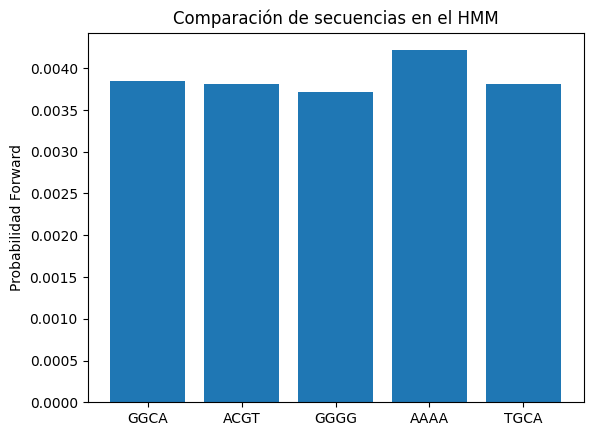

In [14]:
import matplotlib.pyplot as plt

secuencias = {
    "GGCA": [2,2,1,0],
    "ACGT": [0,1,2,3],
    "GGGG": [2,2,2,2],
    "AAAA": [0,0,0,0],
    "TGCA": [3,2,1,0]
}

probs = {name: hmm.evaluar(seq) for name, seq in secuencias.items()}

plt.bar(probs.keys(), probs.values())
plt.ylabel("Probabilidad Forward")
plt.title("Comparación de secuencias en el HMM")
plt.show()


=== Resultados para secuencias largas ===

long1_12
Secuencia : GGGCCAAGGCAT
Índices   : [2, 2, 2, 1, 1, 0, 0, 2, 2, 1, 0, 3]
Ruta      : ['H', 'H', 'H', 'H', 'H', 'L', 'L', 'H', 'H', 'H', 'L', 'L']

Probabilidad (Forward): 0.0000000569
--------------------------------------------------
long2_15
Secuencia : AAACATTGGGCCAAT
Índices   : [0, 0, 0, 1, 0, 3, 3, 2, 2, 2, 1, 1, 0, 0, 3]
Ruta      : ['L', 'L', 'L', 'L', 'L', 'L', 'L', 'H', 'H', 'H', 'H', 'H', 'L', 'L', 'L']

Probabilidad (Forward): 0.0000000010
--------------------------------------------------
long3_20
Secuencia : GGCGGGCAAACGTGGCAATT
Índices   : [2, 2, 1, 2, 2, 2, 1, 0, 0, 0, 1, 2, 3, 2, 2, 1, 0, 0, 3, 3]
Ruta      : ['H', 'H', 'H', 'H', 'H', 'H', 'H', 'L', 'L', 'L', 'H', 'H', 'L', 'H', 'H', 'H', 'L', 'L', 'L', 'L']

Probabilidad (Forward): 0.0000000000
--------------------------------------------------

=== Secuencia aleatoria (30 nt) ===
Secuencia : GTTTGAGTAGTAGGGGCAAGGGGGACACGC
Índices   : [2, 3, 3, 3, 2, 0, 2, 3, 0, 2, 

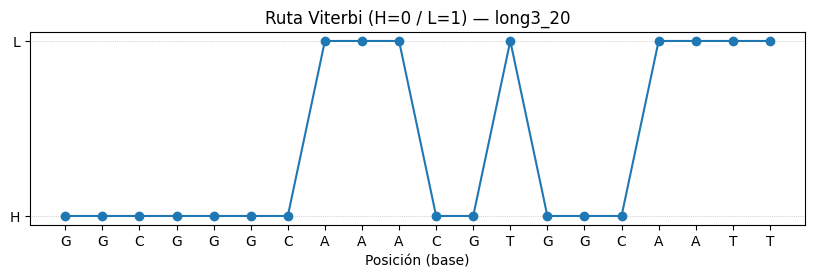

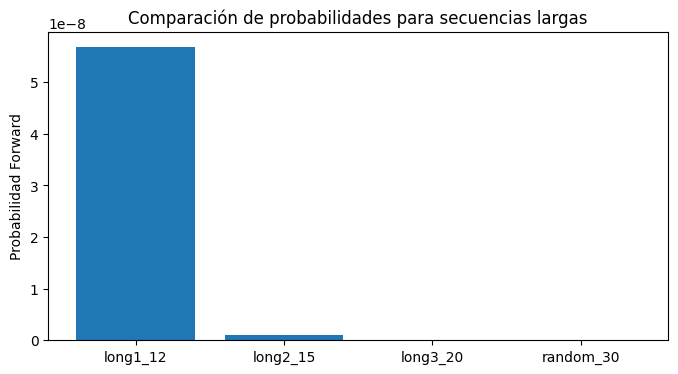


=== Benchmark (reps = 1000) ===
Tiempo total evaluar(): 0.0337 s    (promedio 0.0337 ms/llamada)
Tiempo total reconocer(): 0.0348 s   (promedio 0.0348 ms/llamada)


In [15]:
# Pruebas con secuencias más largas para tu HMM (usa tu módulo hmm ya compilado)
import hmm
import numpy as np
import time
import matplotlib.pyplot as plt

# Mapas útiles
idx2base = {0:'A', 1:'C', 2:'G', 3:'T'}
base2idx = {v:k for k,v in idx2base.items()}
state2label = {0:'H', 1:'L'}  # 0 = H (codificante), 1 = L (no-codificante)

# Función para imprimir secuencia legible y ruta
def pretty_print(seq_idx, ruta):
    seq_bases = [idx2base[i] for i in seq_idx]
    ruta_labels = [state2label[s] for s in ruta]
    print("Secuencia :", "".join(seq_bases))
    print("Índices   :", seq_idx)
    print("Ruta      :", ruta_labels)
    print()

# 1) Secuencias largas definidas (manuales)
long_seqs = {
    "long1_12": [2,2,2,1,1,0,0,2,2,1,0,3],          # mezcla GC y AT
    "long2_15": [0,0,0,1,0,3,3,2,2,2,1,1,0,0,3],    # bloques
    "long3_20": [2,2,1,2,2,2,1,0,0,0,1,2,3,2,2,1,0,0,3,3]  # más variada
}

print("=== Resultados para secuencias largas ===\n")
for name, seq in long_seqs.items():
    prob = hmm.evaluar(seq)
    ruta = hmm.reconocer(seq)
    print(name)
    pretty_print(seq, ruta)
    print(f"Probabilidad (Forward): {prob:.10f}")
    print("-"*50)

# 2) Generar secuencia aleatoria (con distribución controlable)
def random_seq(length, p_A=0.25, p_C=0.25, p_G=0.25, p_T=0.25):
    probs = [p_A, p_C, p_G, p_T]
    arr = np.random.choice([0,1,2,3], size=length, p=probs)
    return arr.tolist()

rand_seq = random_seq(30, p_A=0.2, p_C=0.2, p_G=0.4, p_T=0.2)
print("\n=== Secuencia aleatoria (30 nt) ===")
pretty_print(rand_seq, hmm.reconocer(rand_seq))
print("Prob (Forward):", hmm.evaluar(rand_seq))

# 3) Visualizar ruta (plot de estados por posición) para una secuencia cualquiera
seq = long_seqs["long3_20"]
ruta = hmm.reconocer(seq)
bases = [idx2base[i] for i in seq]
positions = list(range(1, len(seq)+1))

plt.figure(figsize=(10,2.5))
plt.plot(positions, ruta, marker='o')          # no fijamos colores
plt.yticks([0,1], ['H','L'])
plt.xticks(positions, bases)
plt.xlabel("Posición (base)")
plt.title("Ruta Viterbi (H=0 / L=1) — long3_20")
plt.grid(axis='y', linestyle=':', linewidth=0.5)
plt.show()

# 4) Comparar probabilidades entre varias secuencias (barra)
names = list(long_seqs.keys()) + ["random_30"]
seqs_for_plot = list(long_seqs.values()) + [rand_seq]
probs = [hmm.evaluar(s) for s in seqs_for_plot]

plt.figure(figsize=(8,4))
plt.bar(names, probs)
plt.ylabel("Probabilidad Forward")
plt.title("Comparación de probabilidades para secuencias largas")
plt.show()

# 5) Micro-benchmark: tiempo de evaluar() y reconocer() repetidas veces
reps = 1000
test_seq = rand_seq  # secuencia de 30 nt
start = time.perf_counter()
for _ in range(reps):
    _ = hmm.evaluar(test_seq)
t_eval = time.perf_counter() - start

start = time.perf_counter()
for _ in range(reps):
    _ = hmm.reconocer(test_seq)
t_vit = time.perf_counter() - start

print("\n=== Benchmark (reps = {}) ===".format(reps))
print(f"Tiempo total evaluar(): {t_eval:.4f} s    (promedio {t_eval/reps*1000:.4f} ms/llamada)")
print(f"Tiempo total reconocer(): {t_vit:.4f} s   (promedio {t_vit/reps*1000:.4f} ms/llamada)")


In [16]:
import time
import hmm  # tu librería dinámica en C++
import numpy as np

# === Datos de prueba (50,000 bases) ===
seq = np.random.choice([0, 1, 2, 3], size=50_000).tolist()

# === Versión C++ (usa tu librería) ===
start = time.perf_counter()
hmm.evaluar(seq)  # una sola vez, secuencia larga
t_cpp = time.perf_counter() - start

# === Versión Python (naive Forward) ===
PI = [0.5, 0.5]
A = [[0.5, 0.5],
     [0.4, 0.6]]
B = [[0.2, 0.3, 0.3, 0.2],
     [0.3, 0.2, 0.2, 0.3]]

def forward_py(seq):
    T = len(seq)
    N = 2
    alpha = [[0]*N for _ in range(T)]

    # inicialización
    for j in range(N):
        alpha[0][j] = PI[j] * B[j][seq[0]]

    # recursión
    for t in range(1, T):
        for j in range(N):
            suma = 0
            for i in range(N):
                suma += alpha[t-1][i] * A[i][j]
            alpha[t][j] = suma * B[j][seq[t]]

    # terminación
    return sum(alpha[T-1])

# medir tiempo Python
start = time.perf_counter()
forward_py(seq)  # una sola vez, secuencia larga
t_py = time.perf_counter() - start

# === Resultados ===
print("Tiempo con librería dinámica C++:", t_cpp, "s")
print("Tiempo base Python:", t_py, "s")
print("C++ es", t_py/t_cpp, "veces más rápido")

Tiempo con librería dinámica C++: 0.042720293999991554 s
Tiempo base Python: 0.06758591300001626 s
C++ es 1.582056364125903 veces más rápido


In [17]:
import time
import hmm  # tu librería dinámica en C++
import numpy as np
import math

def forward_py(seq, PI, A, B, N):
    T = len(seq)
    alpha = [[0]*N for _ in range(T)]

    # inicialización
    for j in range(N):
        alpha[0][j] = PI[j] * B[j][seq[0]]

    # recursión
    for t in range(1, T):
        for j in range(N):
            suma = 0
            for i in range(N):
                suma += alpha[t-1][i] * A[i][j]
            alpha[t][j] = suma * B[j][seq[t]]

    # terminación
    return sum(alpha[T-1])


# === Experimentos ===
seq_lengths = [200, 2_000, 20_000, 50_000]
states = [2, 5, 10]

for N in states:
    print(f"\n=== {N} estados ===")
    # distribuciones iniciales y matrices aleatorias normalizadas
    PI = np.random.dirichlet(np.ones(N)).tolist()
    A = np.random.dirichlet(np.ones(N), size=N).tolist()
    B = np.random.dirichlet(np.ones(4), size=N).tolist()

    for T in seq_lengths:
        seq = np.random.choice([0,1,2,3], size=T).tolist()

        # --- C++ ---
        start = time.perf_counter()
        hmm.evaluar(seq)   # tu forward en C++
        t_cpp = time.perf_counter() - start

        # --- Python ---
        start = time.perf_counter()
        forward_py(seq, PI, A, B, N)
        t_py = time.perf_counter() - start

        print(f"Tamaño={T:>6} | C++: {t_cpp:.4f}s | Py: {t_py:.4f}s | Speedup: {t_py/t_cpp:.2f}x")



=== 2 estados ===
Tamaño=   200 | C++: 0.0006s | Py: 0.0011s | Speedup: 1.84x
Tamaño=  2000 | C++: 0.0018s | Py: 0.0033s | Speedup: 1.85x
Tamaño= 20000 | C++: 0.0168s | Py: 0.0215s | Speedup: 1.28x
Tamaño= 50000 | C++: 0.0371s | Py: 0.1117s | Speedup: 3.01x

=== 5 estados ===
Tamaño=   200 | C++: 0.0002s | Py: 0.0006s | Speedup: 3.24x
Tamaño=  2000 | C++: 0.0016s | Py: 0.0071s | Speedup: 4.47x
Tamaño= 20000 | C++: 0.0164s | Py: 0.0710s | Speedup: 4.32x
Tamaño= 50000 | C++: 0.0379s | Py: 0.2325s | Speedup: 6.13x

=== 10 estados ===
Tamaño=   200 | C++: 0.0002s | Py: 0.0019s | Speedup: 9.47x
Tamaño=  2000 | C++: 0.0018s | Py: 0.0218s | Speedup: 12.43x
Tamaño= 20000 | C++: 0.0160s | Py: 0.2394s | Speedup: 15.00x
Tamaño= 50000 | C++: 0.0386s | Py: 0.5942s | Speedup: 15.38x
